In [1]:
#pip install nibabel

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as ndimage
from skimage.morphology import ball, binary_closing, remove_small_objects, binary_dilation, binary_erosion


In [2]:
path_to_data = '../3702_left_knee.nii/3702_left_knee.nii'

In [3]:
ct_images_vol = nib.load(path_to_data)

In [4]:
#type of object
type(ct_images_vol)

nibabel.nifti1.Nifti1Image

In [5]:
print(ct_images_vol.header)
#dim             : [  3 512 512 216   1   1   1   1]
#dim[0] = 3: This is a 3D image volume.
#dim[1:4] = 512, 512, 216: Shape is (512, 512, 216) → Width × Height × Depth (Z-slices).
# Remaining values (1s) are placeholders for higher dimensions like time (not used here).

#pixdim          : [1.       0.869141 0.869141 2.       0.       0.       0.       0.      ]
# physical size of each voxel (in mm):
#### pixdim[1] = 0.869 mm → voxel width (X)
#### pixdim[2] = 0.869 mm → voxel height (Y)
#### pixdim[3] = 2.000 mm → voxel depth (Z)

#datatype        : int32 ; bitpix          : 32
# Voxel values are stored as 32-bit signed integers (int32). This matters when doing calculations or rescaling intensities.



<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 216   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.869141 0.869141 2.       0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 222.5
qoffset_y       : 222.5
qoffset_z       : -900.5
s

## Summary

Shape: (512, 512, 216) → 216 axial CT slices of 512×512 pixels

Voxel size: (0.869 × 0.869 × 2.0 mm³)

Datatype: 32-bit integer

Physical size of volume (approx.):

Width: 512 × 0.869 mm ≈ 445 mm

Height: 512 × 0.869 mm ≈ 445 mm

Depth: 216 × 2.0 mm = 432 mm



In [6]:
# Use nibabel to verify orientation
from nibabel.orientations import aff2axcodes

affine = ct_images_vol.affine
orientation = aff2axcodes(affine)
print("Orientation:", orientation)

# if Z corresponds to slice direction → you're in axial view.


Orientation: ('L', 'P', 'S')


In [7]:
ct_images_vol_data = ct_images_vol.get_fdata()
print(type(ct_images_vol_data)) # get_fdata() returned numpy.mmap which accesses files from disk instead of loading to ram
ct_images_vol_data = np.array(ct_images_vol_data) # load fully into ram for faster processing
print(type(ct_images_vol_data))


<class 'numpy.memmap'>
<class 'numpy.ndarray'>


In [8]:
print(f"shape of data: {ct_images_vol_data.shape}")

shape of data: (512, 512, 216)


# Visualize Slices

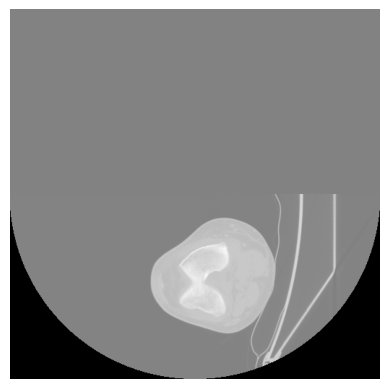

In [9]:
plt.imshow(ct_images_vol_data[:, :, 108], cmap="gray") #grab images along axial plane
plt.axis('off')
plt.show()

In [10]:
from ipywidgets import interact, fixed

def view_axial_slice(z, vol_data):
    plt.imshow(vol_data[:, :, z], cmap='gray')
    plt.axis('off')
    plt.title(f"Axial Slice {z}")
    plt.show()

interact(view_axial_slice, z=(0, ct_images_vol_data.shape[2] - 1), vol_data = fixed(ct_images_vol_data))

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

<function __main__.view_axial_slice(z, vol_data)>

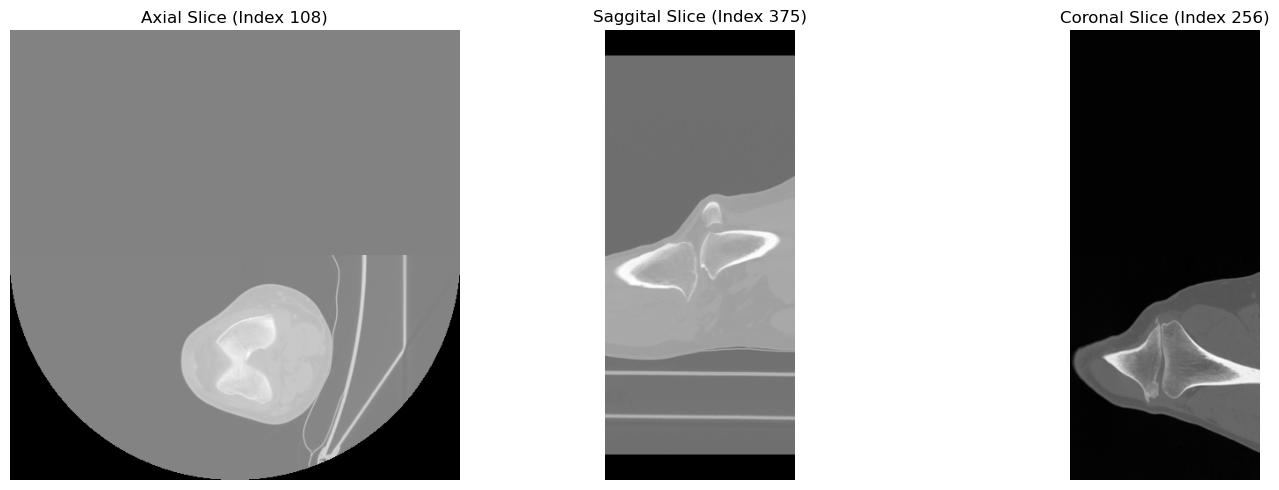

In [11]:
def plot_slices(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial slice 
    axes[0].imshow(data[:, :, 108], cmap='gray')
    axes[0].set_title('Axial Slice (Index 108)')
    axes[0].axis('off')

    # Coronal slice
    axes[1].imshow(data[375, :, :], cmap='gray')
    axes[1].set_title('Saggital Slice (Index 375)')
    axes[1].axis('off')
    # Sagittal slice
    axes[2].imshow(data[:, 256, :], cmap='gray')
    axes[2].set_title('Coronal Slice (Index 256)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

plot_slices(ct_images_vol_data)

In [12]:
def view_coronal_slice(y, vol_data):
    plt.imshow(vol_data[:,y, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Coronal Slice {y}")
    plt.show()

interact(view_coronal_slice, y=(0, ct_images_vol_data.shape[1] - 1), vol_data = fixed(ct_images_vol_data))

interactive(children=(IntSlider(value=255, description='y', max=511), Output()), _dom_classes=('widget-interac…

<function __main__.view_coronal_slice(y, vol_data)>

In [13]:
def view_sagittal_slice(x, vol_data):
    plt.imshow(vol_data[x,:, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Saggital Slice {x}")
    plt.show()


interact(view_sagittal_slice, x=(0, ct_images_vol_data.shape[0] - 1), vol_data = fixed(ct_images_vol_data))

interactive(children=(IntSlider(value=255, description='x', max=511), Output()), _dom_classes=('widget-interac…

<function __main__.view_sagittal_slice(x, vol_data)>

(array([6.0233760e+06, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.5469923e+07, 3.5547000e+05, 4.5239660e+06, 1.4333500e+05,
        3.8718000e+04, 6.8316000e+04]),
 array([-3024. , -2544.7, -2065.4, -1586.1, -1106.8,  -627.5,  -148.2,
          331.1,   810.4,  1289.7,  1769. ]),
 <BarContainer object of 10 artists>)

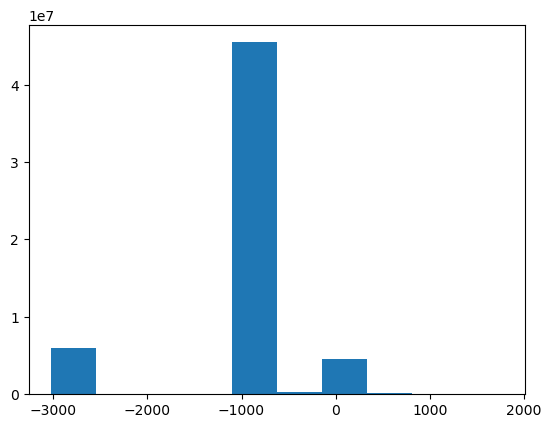

In [ ]:
plt.hist(ct_images_vol_data.flatten()) # histogram of flattened data

In [15]:
np.min(ct_images_vol_data), np.max(ct_images_vol_data) # display maximum and minimum value of HUs present in data

(-3024.0, 1769.0)

Huge spike at ~–1000 HU: air

Moderate peak around 0 to 100 HU: Soft tissue, fat and muscle. Most tissues fall within –100 to +200 HU.

Very small tail going toward 1000 : Bone

Left tail near –3000 : Possibly artifact



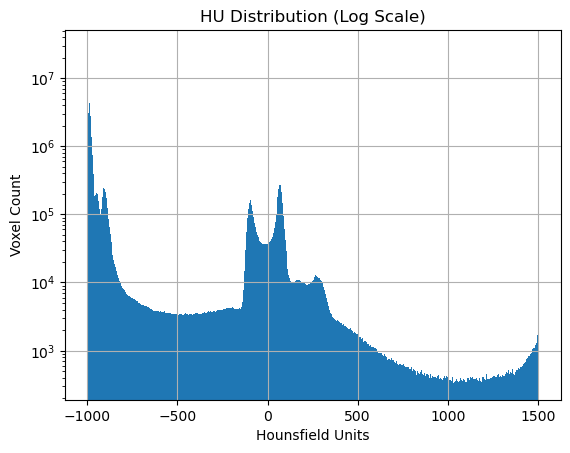

In [16]:
# display voxel count of data from range -1000 HU to 1500 HU in log scale
plt.hist(ct_images_vol_data.flatten(), bins=500, range=(-1000, 1500), log=True)
plt.title("HU Distribution (Log Scale)")
plt.xlabel("Hounsfield Units")
plt.ylabel("Voxel Count")
plt.grid(True)
plt.show()


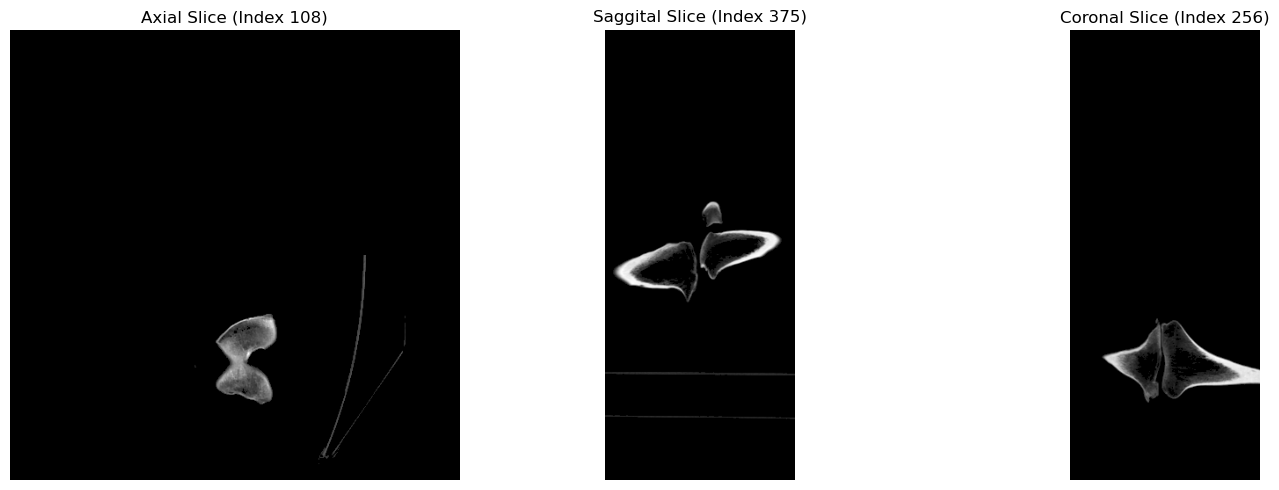

In [17]:
# display bone structures only
bone_only = np.copy(ct_images_vol_data)
bone_only[bone_only <= 150] = 0  # set anything less thatn 150 HU to zero

plot_slices(bone_only)

## Threshold to Isolate Bone

Thresholding isolates bone from surrounding soft tissue and air.

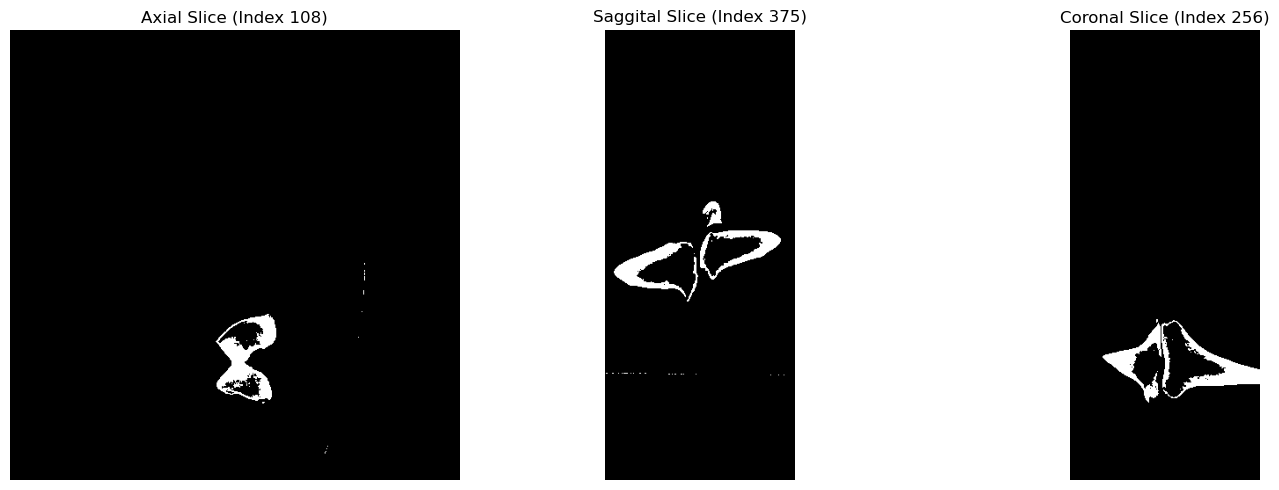

In [18]:
bone_mask = (bone_only > 320)
plot_slices(bone_mask)

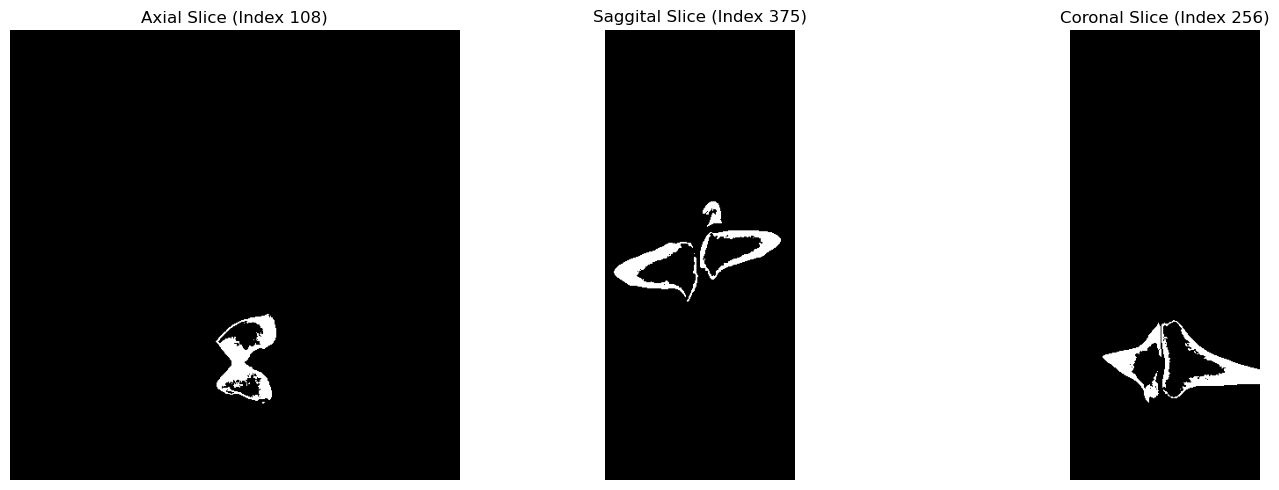

In [19]:
# Remove small objects with less than 500 voxel count
bone_outer = remove_small_objects(bone_mask, min_size=500)

plot_slices(bone_outer)


In [21]:
from scipy.ndimage import binary_fill_holes

filled_mask = np.zeros_like(bone_outer)

for z in range(bone_outer.shape[2]):  # axial slices
    filled_mask[:, :, z] = binary_fill_holes(bone_outer[:, :, z])


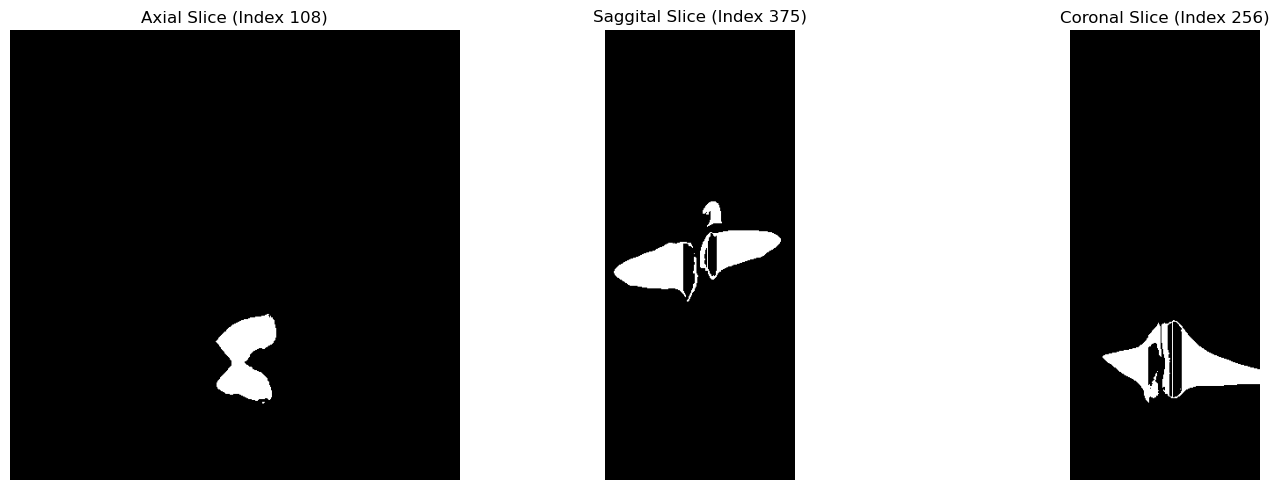

In [22]:
plot_slices(filled_mask)

In [23]:
# Assume `filled_mask` is your binary 3D mask (after axial fill etc.)
labeled_mask, num_components = ndimage.label(filled_mask)

print(f"Found {num_components} components.")


Found 4 components.


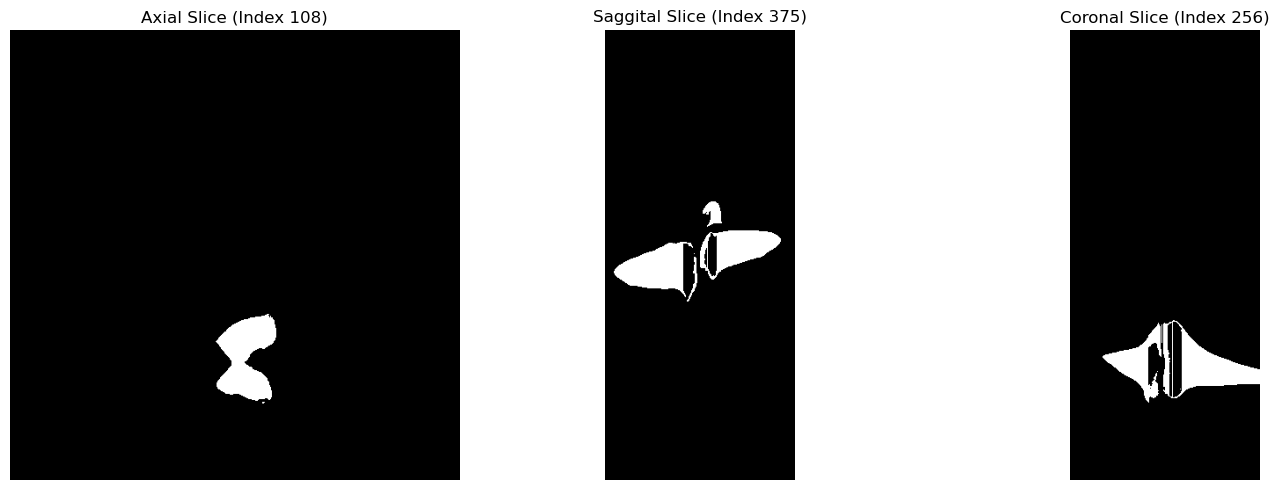

Found 8 components.


In [24]:
# Copy the filled mask
cut_mask = filled_mask.copy()

#
# Zero out that connecting region to separate out femur and tibia
cut_mask[:,:,105:106] = 0

plot_slices(cut_mask)
labeled_mask, num_components = ndimage.label(cut_mask)

print(f"Found {num_components} components.")

In [25]:
import numpy as np
import scipy.ndimage as ndimage

# labeled_mask and num_components already computed in the cell above
# Compute size of each component (starting from label 1)
component_sizes = ndimage.sum(np.ones_like(labeled_mask), labeled_mask, index=np.arange(1, num_components + 1))

# Sort labels by size in descending order
sorted_indices = np.argsort(component_sizes)[::-1]  # largest first

# Get the labels of the two largest components
largest_label_1 = sorted_indices[0] + 1  # +1 because labels start at 1
largest_label_2 = sorted_indices[1] + 1

print(f"Largest component labels: {largest_label_1}, {largest_label_2}")


Largest component labels: 1, 3


In [26]:
largest_component_1 = (labeled_mask == largest_label_1)
largest_component_2 = (labeled_mask == largest_label_2)

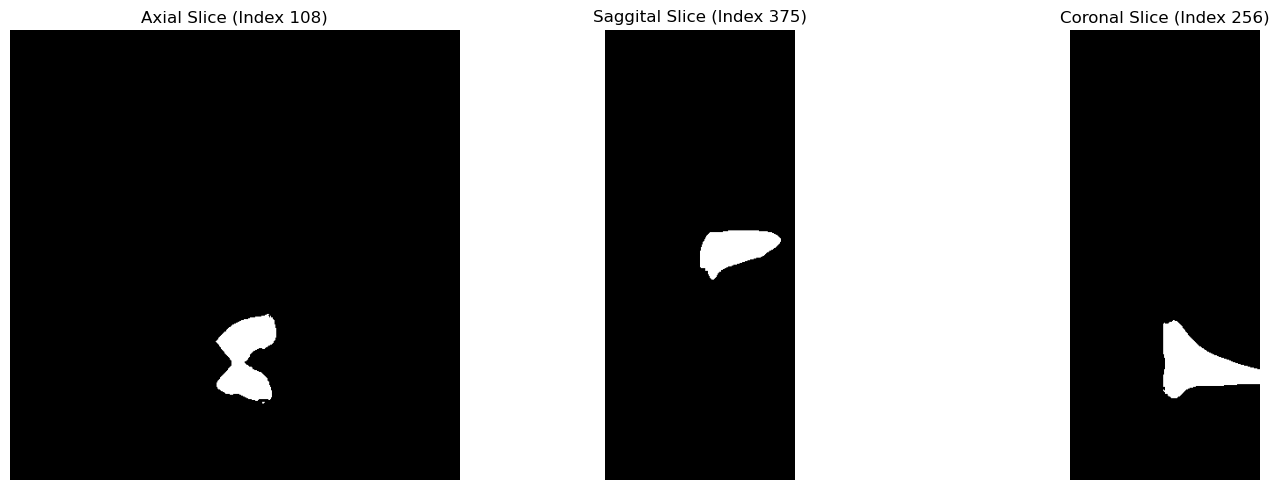

In [27]:
from scipy.ndimage import binary_fill_holes

femur_filled = largest_component_1.copy()

for x in range(largest_component_1.shape[0]):  # loop through sagittal slices
    femur_filled[x, :, :] = binary_fill_holes(largest_component_1[x, :, :])

for z in range(largest_component_1.shape[2]):  # loop through axial slices
    femur_filled[:, :, z] = binary_fill_holes(femur_filled[:, :, z])

for y in range(largest_component_1.shape[1]):  # loop through axial slices
    femur_filled[:, y, :] = binary_fill_holes(femur_filled[:, y, :])


plot_slices(femur_filled)


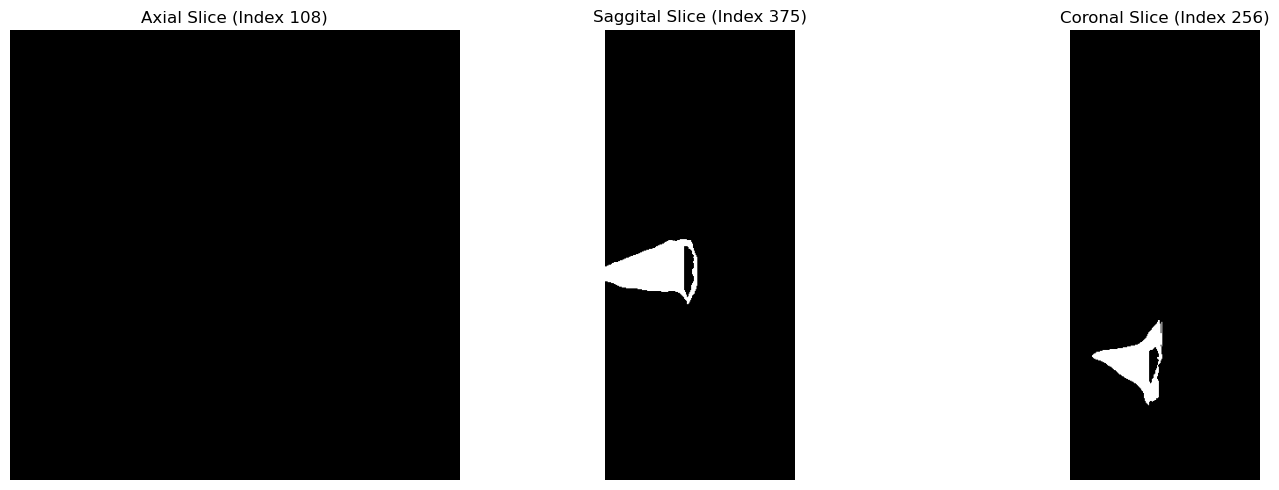

In [28]:
from scipy.ndimage import binary_dilation, binary_fill_holes, binary_erosion
from skimage.morphology import disk

tibia = largest_component_2.copy()  # copy so you can revert if needed

# # Loop over coronal slices (Y-axis)
# for y in range(tibia.shape[1]):
#     slice_2d = tibia[:, y, :]  # coronal slice

#     # Apply mild dilation to connect broken rim
#     dilated = binary_dilation(slice_2d, structure=disk(1))

#     # Fill enclosed holes
#     filled = binary_fill_holes(dilated)

#     tibia[:, y, :] = filled

for z in range(tibia.shape[2]):
    slice_2d = tibia[:, :, z]  # coronal slice

    # Apply mild dilation to connect broken rim
    dilated = binary_dilation(slice_2d, structure=disk(1), iterations=3)
    eroded = binary_erosion(dilated, structure=disk(1), iterations=1)
    # Fill enclosed holes
    filled = binary_fill_holes(dilated)

    tibia[:, :, z] = filled
    
plot_slices(tibia)


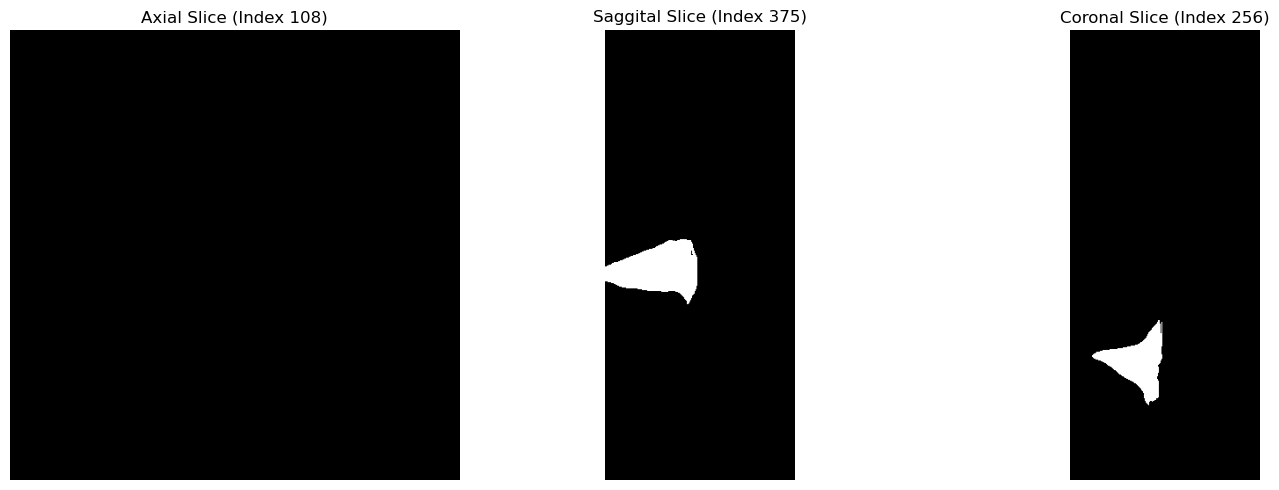

In [29]:
tibia_filled = tibia.copy()
for y in range(tibia.shape[1]):  # coronal view
    tibia_filled[:, y, :] = binary_fill_holes(tibia_filled[:, y, :])
    
for z in range(tibia.shape[2]):  # coronal view
    tibia_filled[:, :, z] = binary_fill_holes(tibia_filled[:, :, z])
    
plot_slices(tibia_filled)



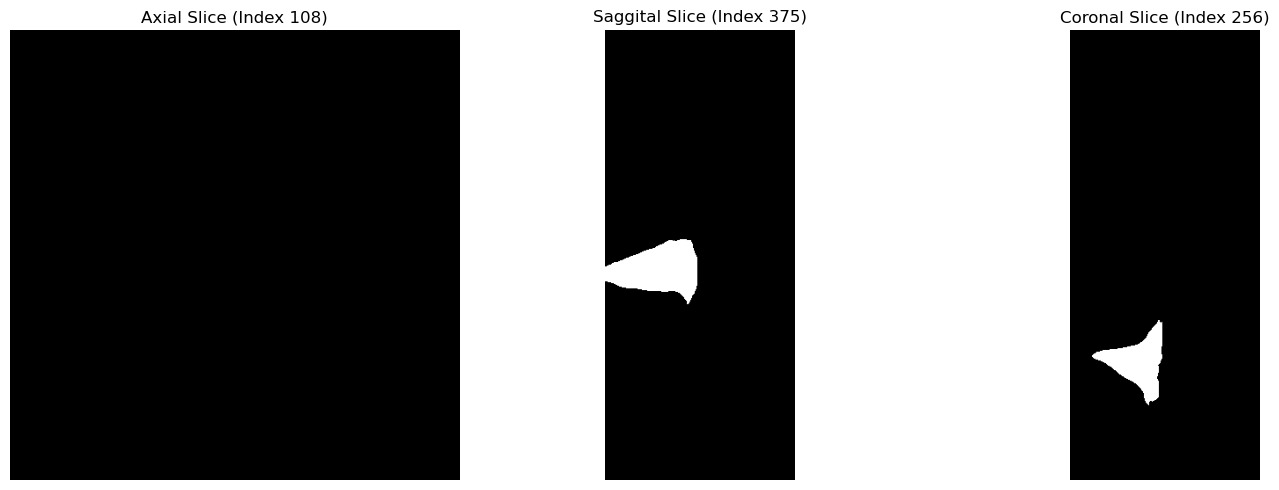

In [33]:

mask = tibia_filled.copy()
# smoothing out the edges
mask = binary_dilation(mask, footprint=ball(1))
mask = binary_erosion(mask, footprint=ball(1))
plot_slices(mask)


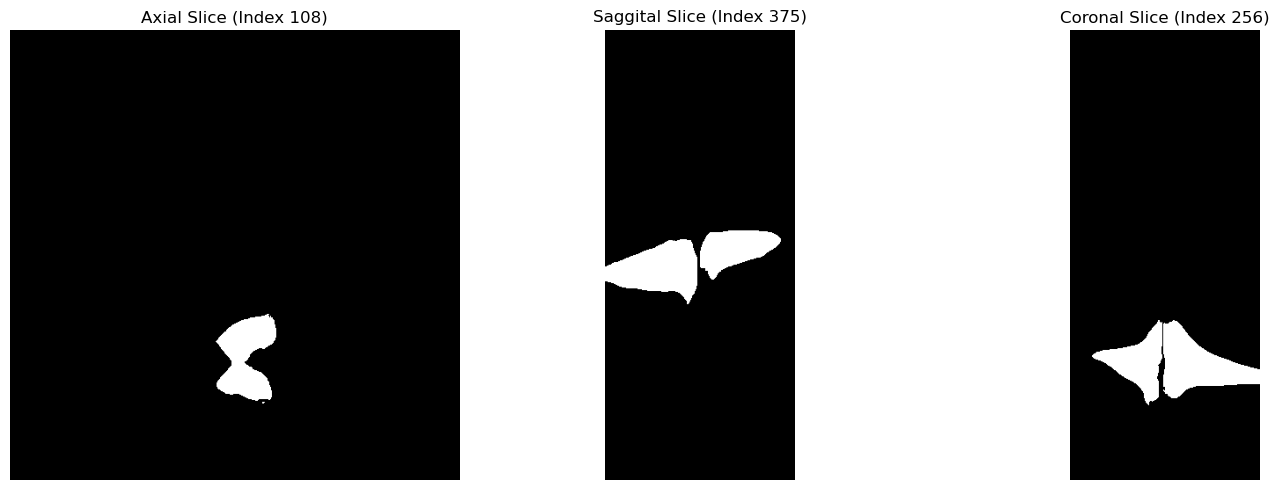

In [34]:
combined_mask = mask | femur_filled

plot_slices(combined_mask)

In [35]:
labeled_mask, num_components = ndimage.label(combined_mask)

print(f"Found {num_components} components.")

# Step 2: Compute size of each component (excluding background)
component_sizes = ndimage.sum(np.ones_like(labeled_mask), labeled_mask, index=np.arange(1, num_components + 1))

# Step 3: Get labels of two largest components
sorted_indices = np.argsort(component_sizes)[::-1]
largest_label_1 = sorted_indices[0] + 1  # +1 because labels start at 1
largest_label_2 = sorted_indices[1] + 1

# Step 4: Use center of mass to determine which is tibia (lower Z)
com1 = ndimage.center_of_mass(labeled_mask == largest_label_1)
com2 = ndimage.center_of_mass(labeled_mask == largest_label_2)

if com1[2] < com2[2]:
    tibia_label = largest_label_1
    femur_label = largest_label_2
else:
    tibia_label = largest_label_2
    femur_label = largest_label_1

print(f"Tibia label: {tibia_label}, Femur label: {femur_label}")

# Step 5: Create labeled mask: 1 = femur, 2 = tibia
final_mask = np.zeros_like(labeled_mask, dtype=np.uint8)
final_mask[labeled_mask == tibia_label] = 1
final_mask[labeled_mask == femur_label] = 2


Found 2 components.
Tibia label: 2, Femur label: 1


In [36]:
labelled_mask = final_mask.astype(np.uint8)  # NIfTI format expects int types

nii_mask = nib.Nifti1Image(labelled_mask, affine=ct_images_vol.affine)

nib.save(nii_mask, "tibia_femur_mask_3.nii.gz")
